In [ ]:
import tensorflow as tf; print(tf.__version__)
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

2.12.0


In [ ]:
dataset, info = tfds.load("oxford_iiit_pet:3.*.*", with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteAP62LE/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteAP62LE/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='/root/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    sp

In [ ]:
def resize(input_image, input_mask):
  input_image = tf.image.resize(input_image, (128, 128), method="nearest")
  input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
  return input_image, input_mask

In [ ]:
def augment(input_image, input_mask):
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)
  return input_image, input_mask

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [ ]:
def load_image_train(datapoint):
  input_image = datapoint["image"]
  input_mask = datapoint["segmentation_mask"]
  input_image, input_mask = resize(input_image, input_mask)
  input_image, input_mask = augment(input_image, input_mask)
  input_image, input_mask = normalize(input_image, input_mask)
  return input_image, input_mask

def load_image_test(datapoint):
  input_image = datapoint["image"]
  input_mask = datapoint["segmentation_mask"]
  input_image, input_mask = resize(input_image, input_mask)
  input_image, input_mask = normalize(input_image, input_mask)
  return input_image, input_mask

In [ ]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
BATCH_SIZE  = 64
BUFFER_SIZE = 1000

train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)

test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))
  title = ["Input Image", "True Mask", "Predicted Mask"]
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis("off")
  plt.show()

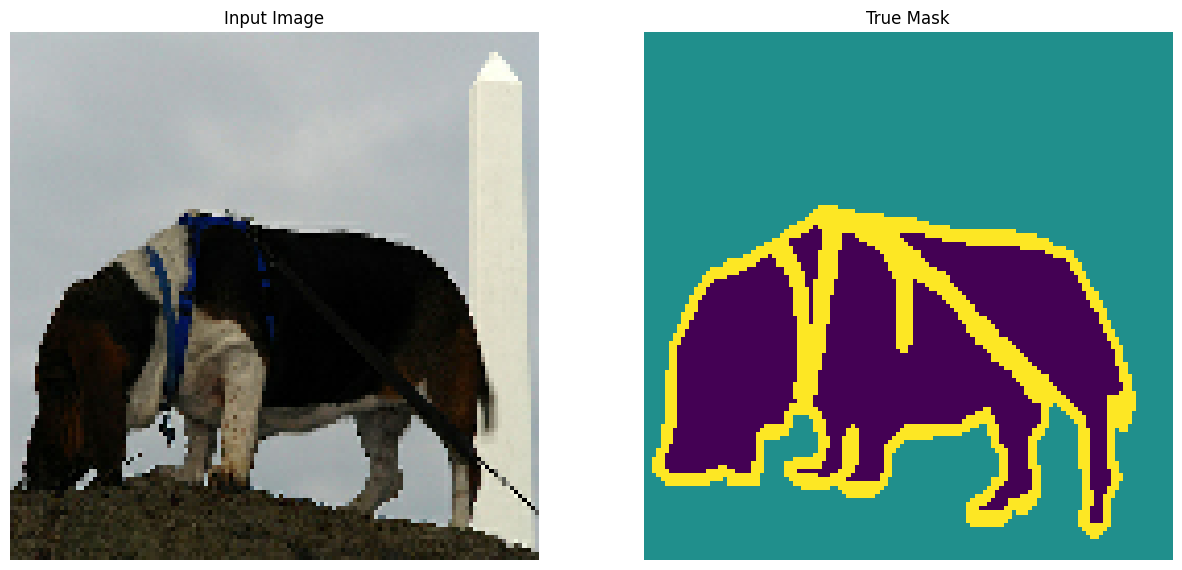

In [ ]:
sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [ ]:
def double_conv_block(x, n_filters):
  x = layers.Conv2D(n_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
  x = layers.Conv2D(n_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
  return x

In [ ]:
def downsample_block(x, n_filters):
  f = double_conv_block(x, n_filters)
  p = layers.MaxPool2D(2)(f)
  p = layers.Dropout(0.3)(p)
  return f, p

In [ ]:
def upsample_block(x, conv_features, n_filters):
  x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
  x = layers.concatenate([x, conv_features])
  x = layers.Dropout(0.3)(x)
  x = double_conv_block(x, n_filters)
  return x

In [ ]:
def build_unet_model():
  inputs = layers.Input(shape=(128, 128, 3))

  f1, p1 = downsample_block(inputs, 64)

  f2, p2 = downsample_block(p1, 128)

  f3, p3 = downsample_block(p2, 256)

  f4, p4 = downsample_block(p3, 512)

  bottleneck = double_conv_block(p4, 1024)

  u6 = upsample_block(bottleneck, f4, 512)

  u7 = upsample_block(u6, f3, 256)

  u8 = upsample_block(u7, f2, 128)

  u9 = upsample_block(u8, f1, 64)

  outputs = layers.Conv2D(3, 1, padding="same", activation="softmax")(u9)

  unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

  return unet_model

In [ ]:
unet_model = build_unet_model()

In [ ]:
unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics="accuracy"
)

In [ ]:
NUM_EPOCHS = 20

TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LENGTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENGTH // BATCH_SIZE // VAL_SUBSPLITS

In [ ]:
model_history = unet_model.fit(
    train_batches,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_batches
)

Epoch 1/20
57/57 [==============================] - 119s 1s/step - loss: 0.9242 - accuracy: 0.5809 - val_loss: 0.8779 - val_accuracy: 0.5864
Epoch 2/20
57/57 [==============================] - 81s 1s/step - loss: 0.7408 - accuracy: 0.6820 - val_loss: 0.6515 - val_accuracy: 0.7340
Epoch 3/20
57/57 [==============================] - 67s 1s/step - loss: 0.6468 - accuracy: 0.7384 - val_loss: 0.5799 - val_accuracy: 0.7704
Epoch 4/20
57/57 [==============================] - 66s 1s/step - loss: 0.5597 - accuracy: 0.7779 - val_loss: 0.5223 - val_accuracy: 0.7965
Epoch 5/20
57/57 [==============================] - 66s 1s/step - loss: 0.5000 - accuracy: 0.8057 - val_loss: 0.5039 - val_accuracy: 0.8045
Epoch 6/20
57/57 [==============================] - 66s 1s/step - loss: 0.4680 - accuracy: 0.8189 - val_loss: 0.4447 - val_accuracy: 0.8276
Epoch 7/20
57/57 [==============================] - 67s 1s/step - loss: 0.4370 - accuracy: 0.8312 - val_loss: 0.4055 - val_accuracy: 0.8421
Epoch 8/20
57/57 [=

In [ ]:
def display_learning_curves(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(NUM_EPOCHS)

    fig = plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label="train accuracy")
    plt.plot(epochs_range, val_acc, label="validataion accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label="train loss")
    plt.plot(epochs_range, val_loss, label="validataion loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    fig.tight_layout()
    plt.show()

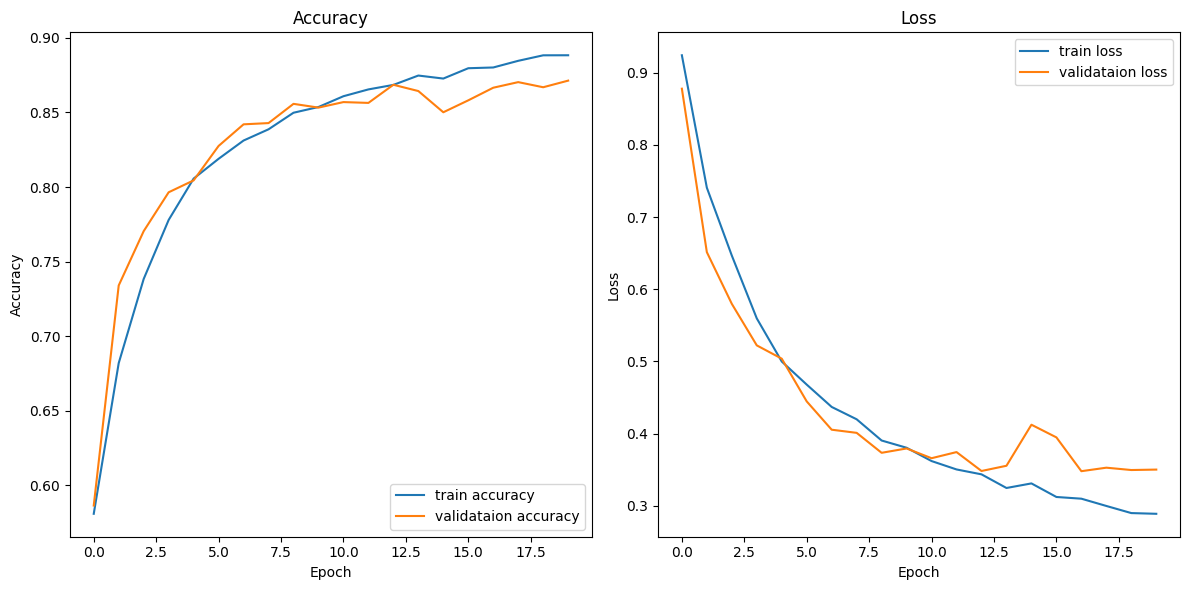

In [ ]:
display_learning_curves(model_history)

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = unet_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([
        sample_image,
        sample_mask,
        create_mask(unet_model.predict(sample_image[tf.newaxis, ...]))
    ])

In [ ]:
count = 0
for i in test_batches:
  count += 1
print(f"Number of Batches: {count}")

Number of Batches: 11


2/2 [==============================] - 1s 10ms/step


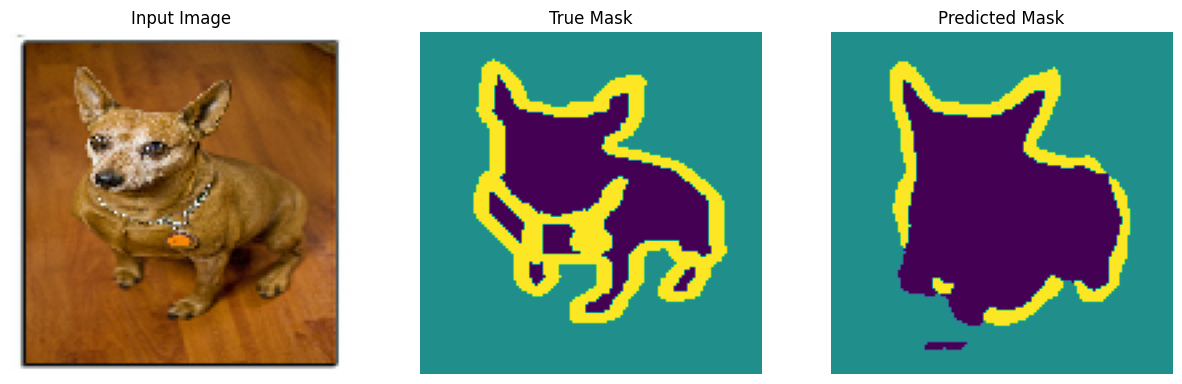

In [ ]:
show_predictions(test_batches)